In [230]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import utils
from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps

In [231]:
from xhistogram.xarray import histogram

In [232]:
from scipy.stats import genextreme as gev
def empirical_return_level(data):
    """
    Compute empirical return level using the algorithm introduced in Tutorial 2
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranks_sp"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranks_sp"] / (n + 1)
    # find return period
    df["period"] = 1 / df["exceedance"]

    df = df[::-1]

    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )
    return out

In [233]:
yearb=1980
yeare=2008

# Define mask
dsm=xr.open_dataset('/data/ghervieux/AFI/mask_usa_for_ERA5crop.nc')
mask=dsm['mask_usa'].load()
#

datadir='/data/ghervieux/AFI'
files=[f'{datadir}/AFI_ERA5_{iyear}_fullUSA.nc' for iyear in range(yearb,yeare+1)]

ds=xr.open_mfdataset(files)

return_periods=[2, 5, 10, 25, 50, 100]
return_afi=np.zeros((len(return_periods),len(ds.lat),len(ds.lon)))*np.nan
Rmethod=np.zeros((len(ds.lat),len(ds.lon)))*np.nan
Tlon=ds.lon.data
Tlat=ds.lat.data


idlat,idlon=np.where(mask==1)

In [234]:
units=ds['AFI'].units

In [235]:
dso=xr.open_dataset(f'{datadir}/afi_return.fullUSA.nc')

# Define list of 4 pts

In [236]:
ptlon=[260,270,205,204]
ptlat=[48,40,68.75,60]

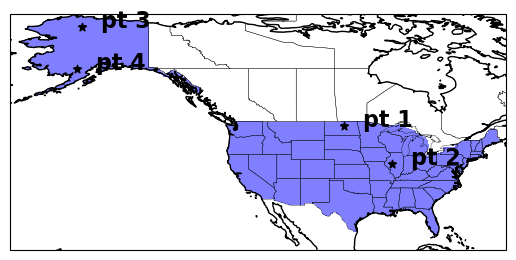

In [237]:
proj=ccrs.LambertConformal()
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection':proj})
cc=mask.where(mask>0).plot.pcolormesh(ax=ax,cmap = cmaps.BlGrYeOrReVi200, levels=np.arange(1,3,1),alpha=0.5, add_colorbar=False)
for ip in range(0,4):
  ax.scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax.text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=16,weight='bold')

state_borders = cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='50m', facecolor='None')
ax.add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.25)
ax.set_extent([190,294,22,62])
ax.coastlines()

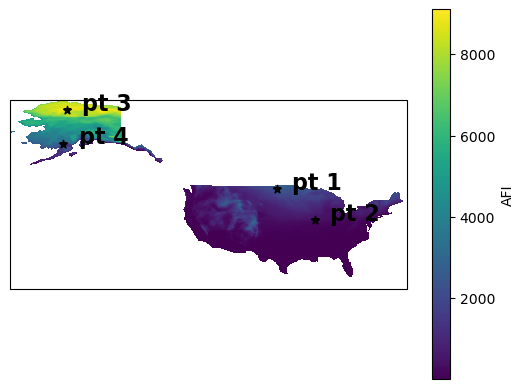

In [238]:
fig, ax = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection':proj})
ds['AFI'].where(ds['AFI']>0.).mean('time').plot(ax=ax)
for ip in range(0,4):
  ax.scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax.text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=16,weight='bold')
ax.set_extent([190,294,22,62])

# Pt 1 

In [239]:
ij=0
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3240269/1693931927.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/1693931927.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/1693931927.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
/tmp/ipykernel_3240269/1693931927.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fonts

Text(0.5, 1.0, 'AFI at (260$\\degree$E;48$\\degree$N)')

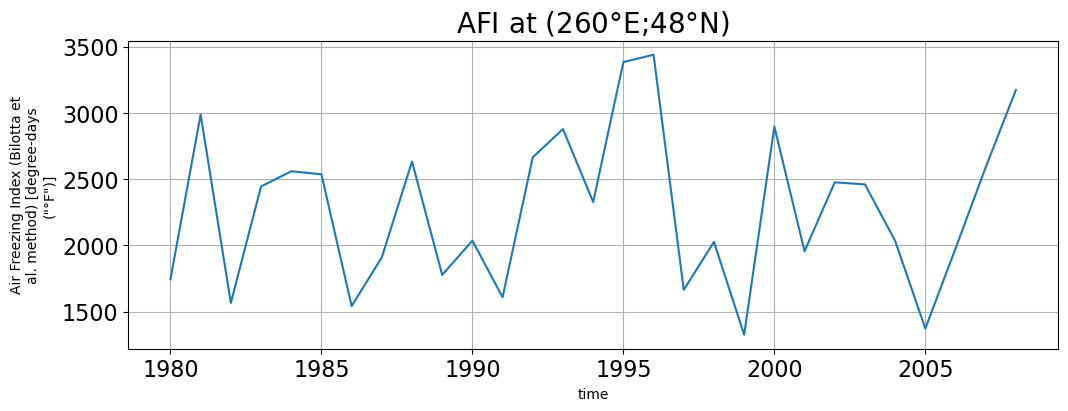

In [240]:
fig, axs =plt.subplots(nrows=1,ncols=1,figsize=(12,4))
afi.plot(ax=axs)
axs.grid()
axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fontsize=16)
axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)


# With gev function as called by Claude

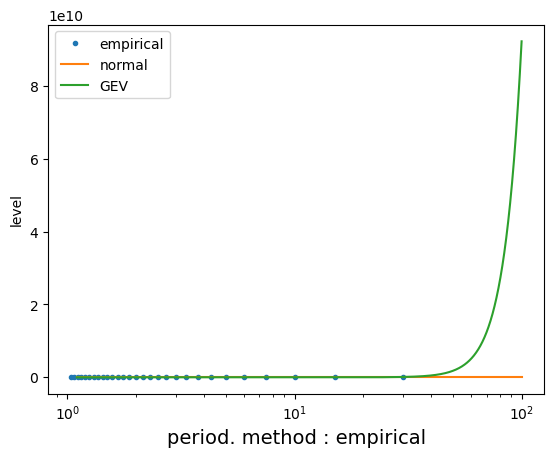

In [241]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]


shape, loc, scale = gev.fit(nonzero_afis)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])


Text(0, 0.5, 'Density')

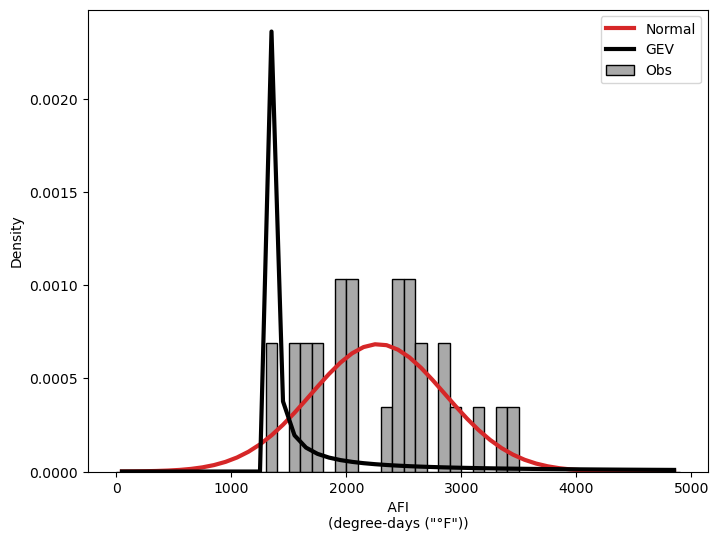

In [242]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# With gev function called with c=0 (gumbl) 

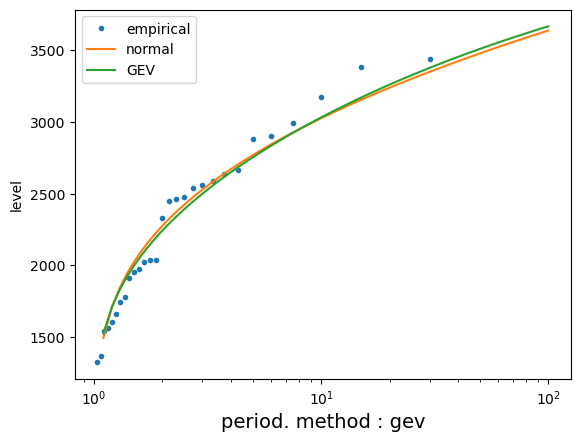

In [243]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]


shape, loc, scale = gev.fit(nonzero_afis,0)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

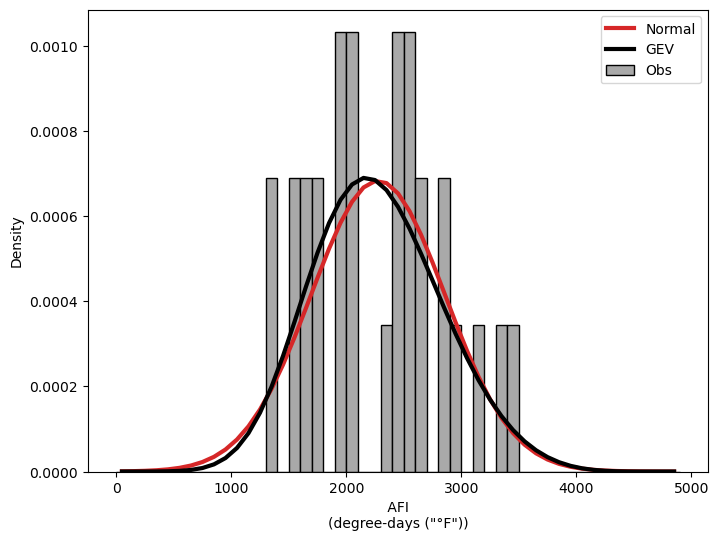

In [244]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# Pt 2 

In [245]:
ij=1
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()
result,method = utils.calculate_bilotta_afi_return_periods(afi,return_periods=return_periods, method='gev')

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
/tmp/ipykernel_3240269/2325202151.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fonts

Text(0.5, 1.0, 'AFI at (270$\\degree$E;40$\\degree$N)')

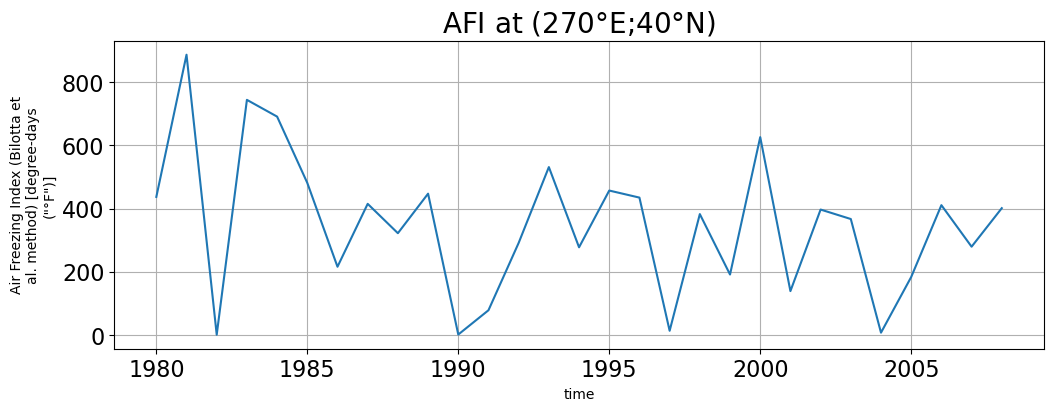

In [246]:
fig, axs =plt.subplots(nrows=1,ncols=1,figsize=(12,4))
afi.plot(ax=axs)
axs.grid()
axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fontsize=16)
axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)

# With gev function as called by Claude

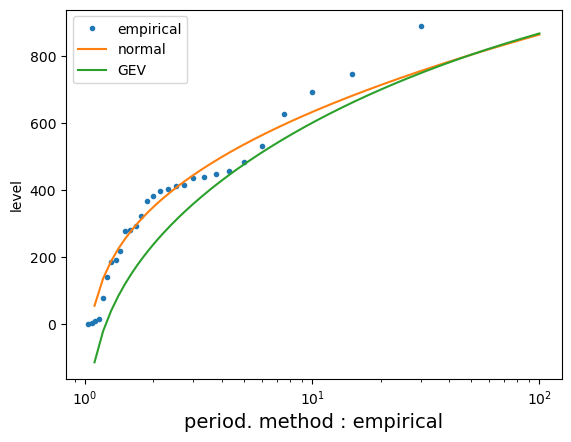

In [247]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]


shape, loc, scale = gev.fit(nonzero_afis)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

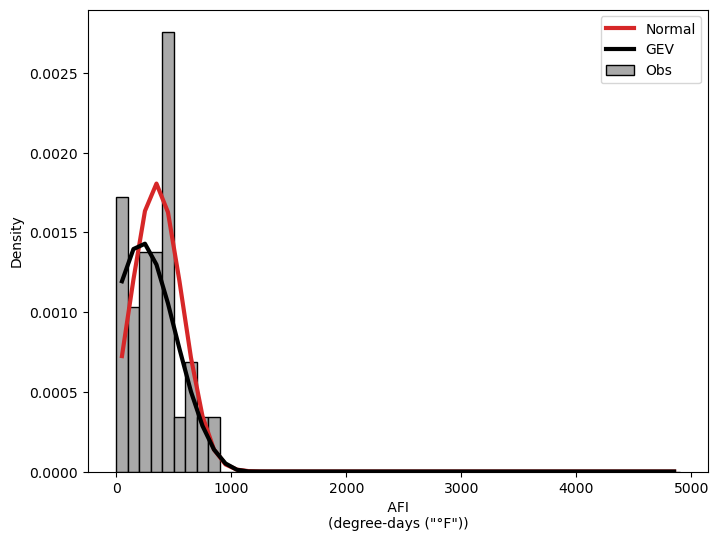

In [248]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# With gev function called with c=0 (gumbl) 

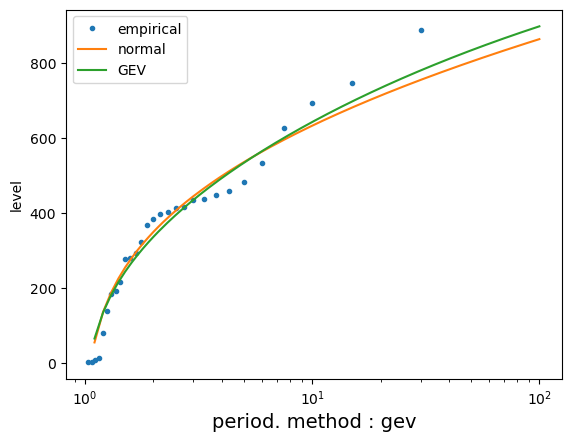

In [249]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]


shape, loc, scale = gev.fit(nonzero_afis, 0)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

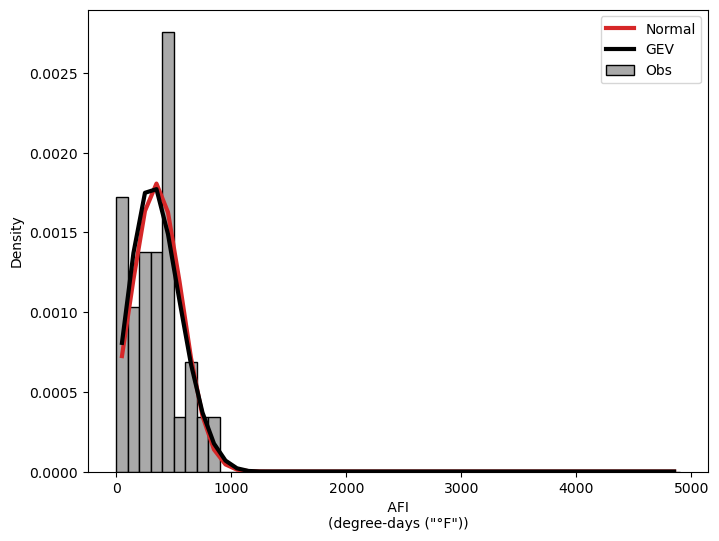

In [250]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# Pt 3

In [276]:
ij=2
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()
result,method = utils.calculate_bilotta_afi_return_periods(afi,return_periods=return_periods, method='gev')

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
/tmp/ipykernel_3240269/2325202151.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fonts

Text(0.5, 1.0, 'AFI at (205$\\degree$E;68.75$\\degree$N)')

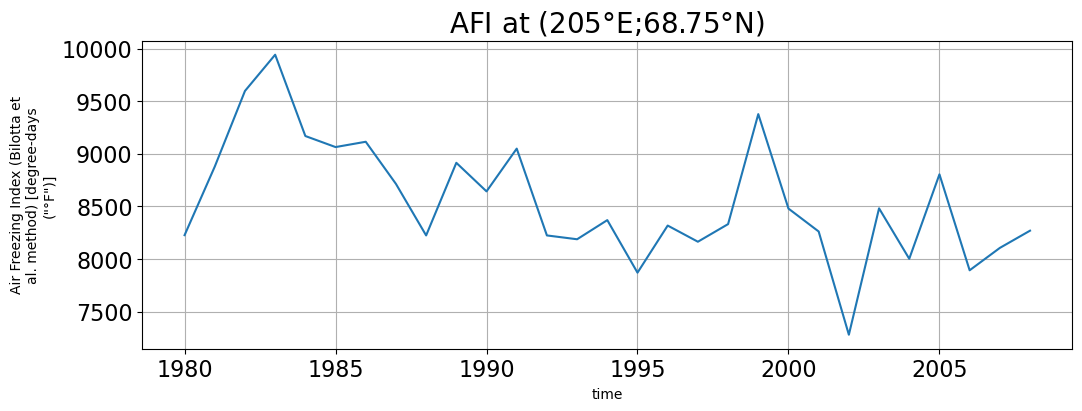

In [277]:
fig, axs =plt.subplots(nrows=1,ncols=1,figsize=(12,4))
afi.plot(ax=axs)
axs.grid()
axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fontsize=16)
axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)

# With gev function as called by Claude

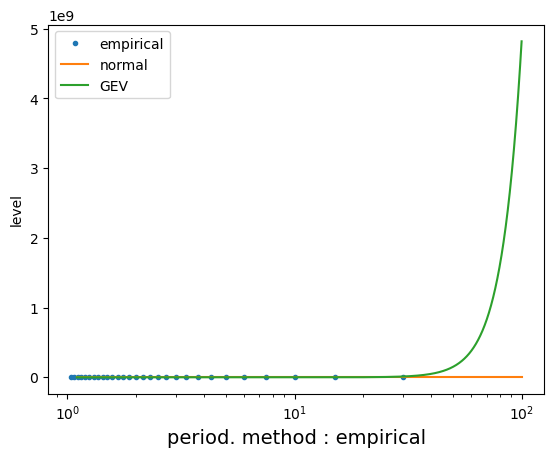

In [278]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]


shape, loc, scale = gev.fit(nonzero_afis)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

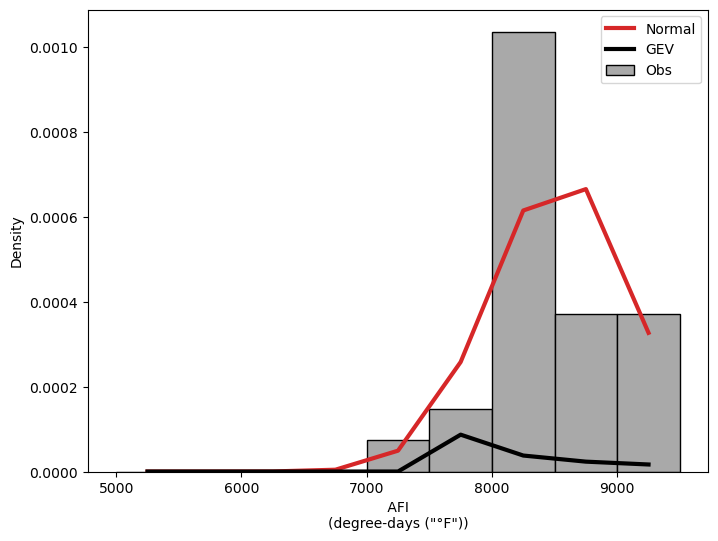

In [279]:
#####
##### PDF Plot
#####

bins = np.arange(5000,10000,500)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# With gev function called with c=0 (gumbl) 

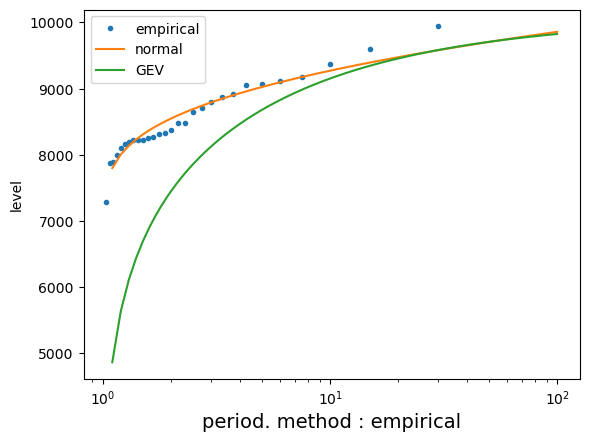

In [280]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

shape, loc, scale = gev.fit(nonzero_afis, 0)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

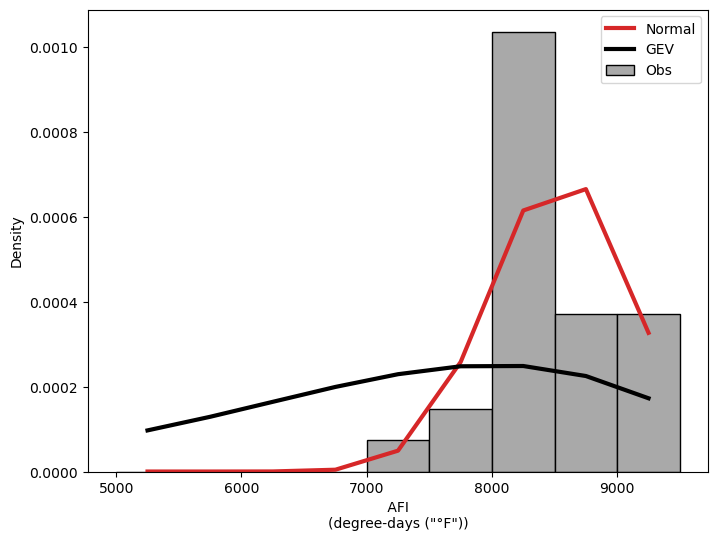

In [281]:
#####
##### PDF Plot
#####

bins = np.arange(5000,10000,500)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# Pt 4

In [257]:
ij=3
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()
result,method = utils.calculate_bilotta_afi_return_periods(afi,return_periods=return_periods, method='gev')

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
/tmp/ipykernel_3240269/2325202151.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fonts

Text(0.5, 1.0, 'AFI at (204$\\degree$E;60$\\degree$N)')

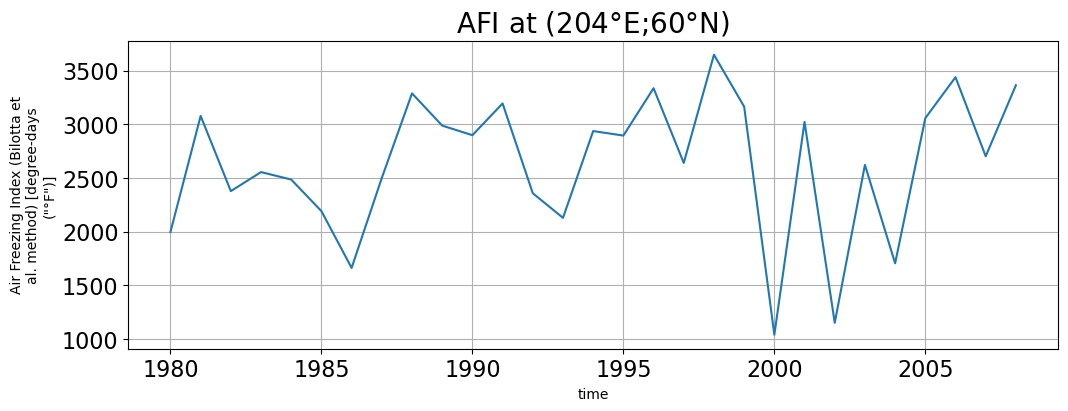

In [258]:
fig, axs =plt.subplots(nrows=1,ncols=1,figsize=(12,4))
afi.plot(ax=axs)
axs.grid()
axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fontsize=16)
axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)

# With gev function as called by Claude

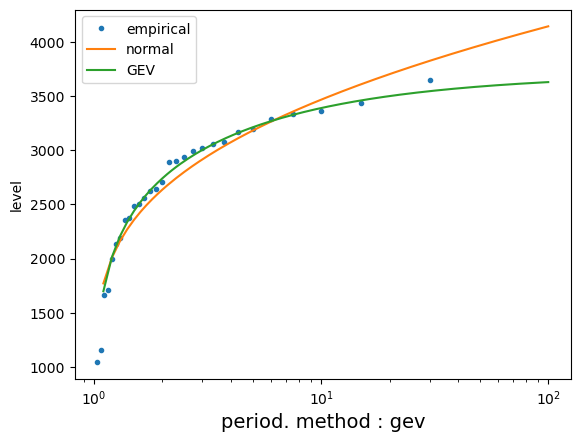

In [259]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]


shape, loc, scale = gev.fit(nonzero_afis)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

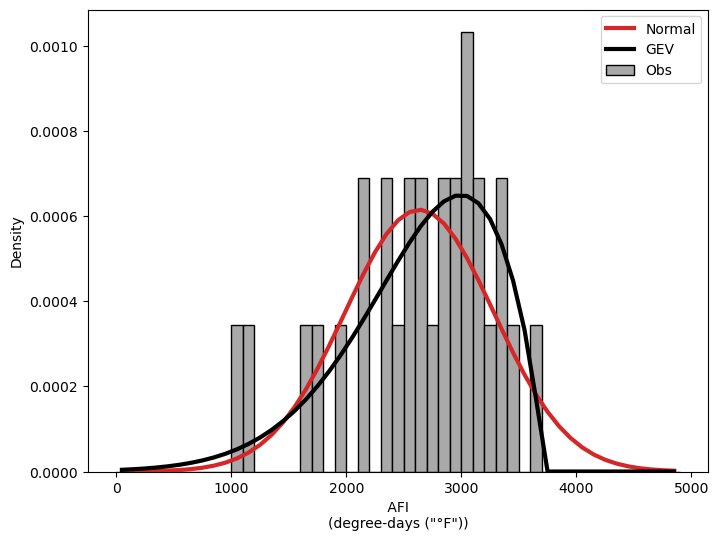

In [ ]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# With gev function called with c=0 (gumbl) 

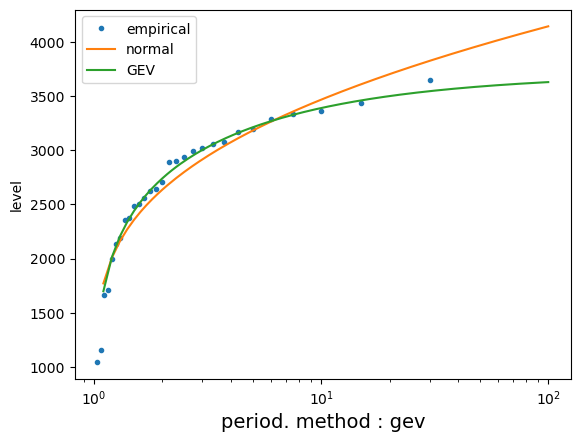

In [261]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

shape, loc, scale = gev.fit(nonzero_afis, 0)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

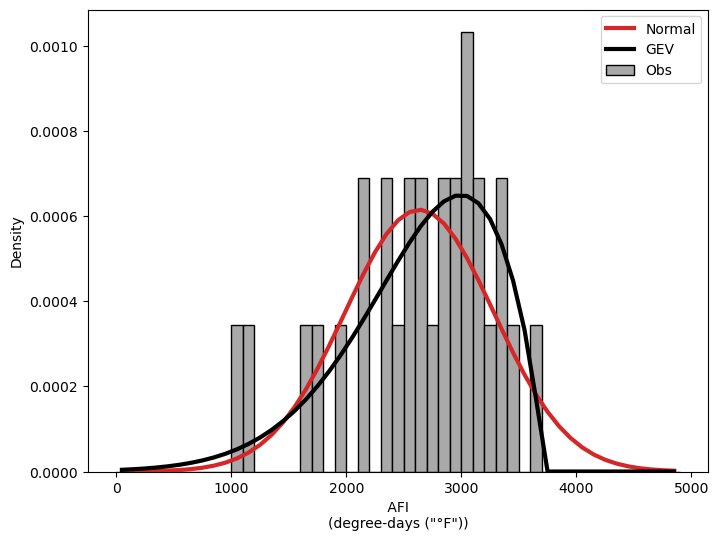

In [262]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

# Problematic pts

In [263]:

ilon=264.25
ilat=37
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
/tmp/ipykernel_3240269/2325202151.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fonts

Text(0.5, 1.0, 'AFI at (264.25$\\degree$E;37$\\degree$N)')

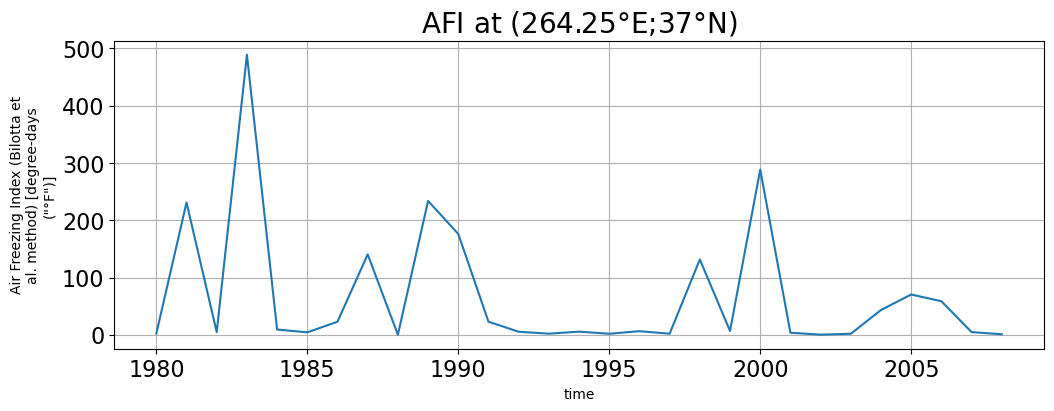

In [264]:
fig, axs =plt.subplots(nrows=1,ncols=1,figsize=(12,4))
afi.plot(ax=axs)
axs.grid()
axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fontsize=16)
axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)

In [265]:
min(afi)

<xarray.DataArray 'AFI' ()> Size: 8B
array(0.26757812)
Coordinates:
    time     int64 8B 1988
    lat      float64 8B 37.0
    lon      float64 8B 264.2
Attributes:
    units:        degree-days ("°F")
    long_name:    Air Freezing Index (Bilotta et al. method)
    description:  Difference between highest and lowest extrema points of cum...

29


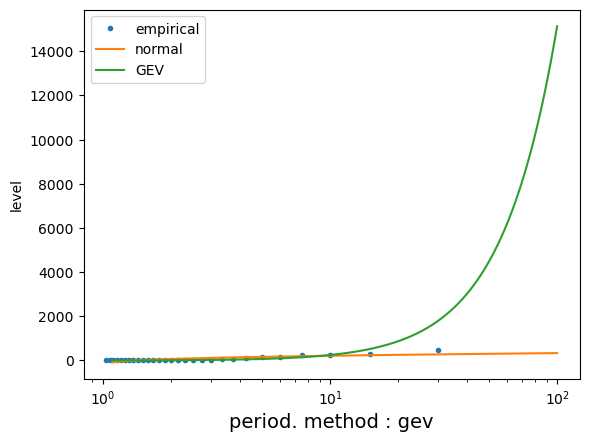

In [266]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]
print(len(nonzero_afis))
shape, loc, scale = gev.fit(nonzero_afis, 0)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

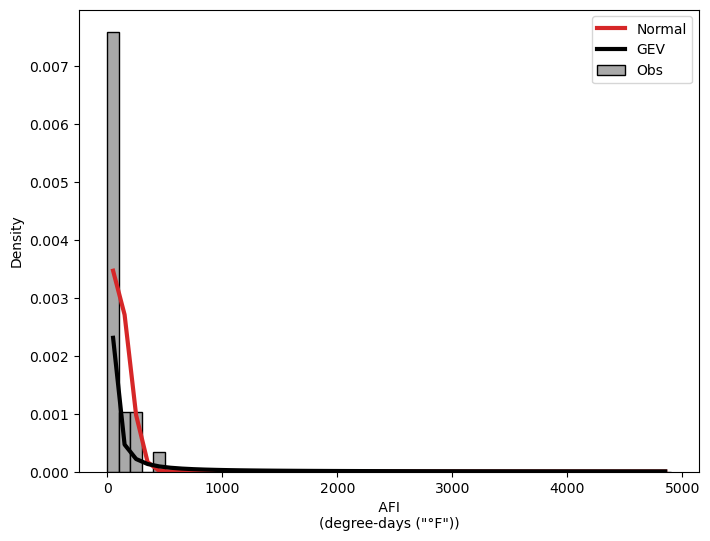

In [267]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")

In [268]:
ilon=241.25
ilat=46.25
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:6: SyntaxWarning: invalid escape sequence '\d'
  axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)
/tmp/ipykernel_3240269/2325202151.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
/tmp/ipykernel_3240269/2325202151.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fonts

Text(0.5, 1.0, 'AFI at (241.25$\\degree$E;46.25$\\degree$N)')

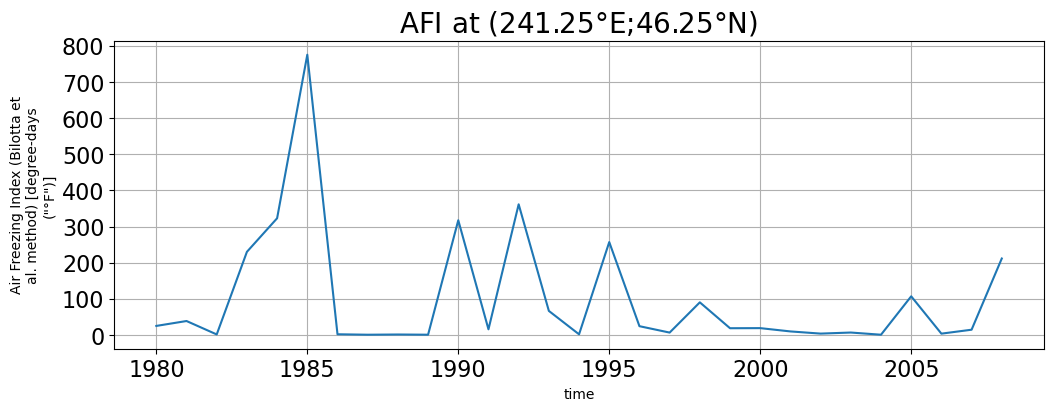

In [269]:
fig, axs =plt.subplots(nrows=1,ncols=1,figsize=(12,4))
afi.plot(ax=axs)
axs.grid()
axs.set_xticklabels([round(ix) for ix in axs.get_xticks()[:]],fontsize=16)
axs.set_yticklabels([round(ix) for ix in axs.get_yticks()[:]],fontsize=16)
axs.set_title(f'AFI at ({ilon}$\degree$E;{ilat}$\degree$N)',fontsize=20)

29


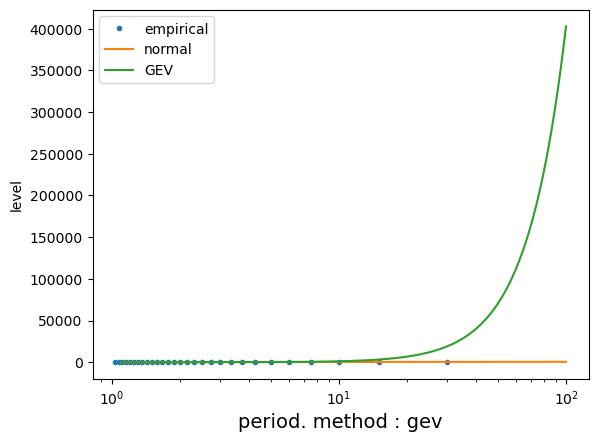

In [270]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]
print(len(nonzero_afis))
shape, loc, scale = gev.fit(nonzero_afis, 0)
# setup plots
fig, ax = plt.subplots()
# get empirical return levels and plot them
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker=".", linestyle="None")
# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels
ax.plot(
    years,
    stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
)
_, p_value = stats.kstest(nonzero_afis, 'genextreme', args=(shape, loc, scale))
if p_value < 0.05:
   ax.set_xlabel('period. method : empirical',fontsize=14) 
else:
   ax.set_xlabel('period. method : gev',fontsize=14)    
# calculate and plot the GEV distribution, note the negtive shape parameter
ax.plot(years, gev.ppf(1 - 1 / years, shape, loc=loc, scale=scale))
# set x axis to log scale
ax.set_xscale("log")
# show legend
ax.legend(["empirical", "normal", "GEV"])

Text(0, 0.5, 'Density')

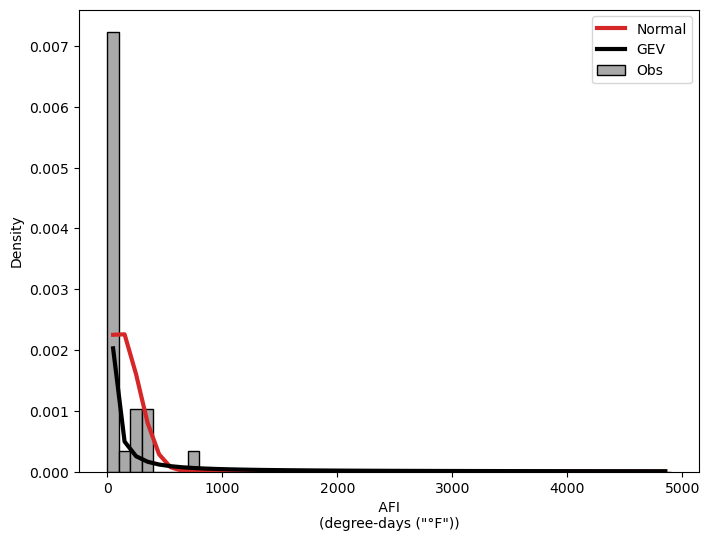

In [271]:
#####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="C3",lw=3,label="Normal")
# GEV distribution
ax.plot(x100, gev.pdf(x100, shape, loc=loc, scale=scale), c="k", lw=3, label="GEV")

ax.legend()
ax.set_xlabel(f" AFI \n({units})")
ax.set_ylabel("Density")